# Tabular Playground Series Mar 2022

In [1]:
# Installing the modules

!pip3 install kaggle
!pip3 install prophet
!pip3 install pystan==2.19.1.1

     |████████████████████████████████| 65 kB 3.6 MB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640259 sha256=5faa402b1b527fab7a0f6bac9380806675b118b8bff20345324a2c80b7973cb6
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [2]:
# Required modules

import tqdm
import numpy as np
import pandas as pd
import seaborn as sns

from zipfile import ZipFile
from prophet import Prophet
from matplotlib import pyplot as plt

In [3]:
# Config

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

Before running the below cell, upload your kaggle token, to make sure an error doesn't popup.

In [4]:
# Create kaggle folder

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Test the command

!kaggle competitions download -c tabular-playground-series-mar-2022

  0% 0.00/4.71M [00:00<?, ?B/s]
100% 4.71M/4.71M [00:00<00:00, 119MB/s]


In [6]:
# Extract the zip file

with ZipFile('/content/tabular-playground-series-mar-2022.zip', 'r') as zf:
    zf.extractall('./')

## Loading the data

In [7]:
# Load the data

train = pd.read_csv('train.csv', index_col='row_id', parse_dates=['time'])
train.head()

,time,x,y,direction,congestion
row_id,,,,,
0,1991-04-01,0,0,EB,70
1,1991-04-01,0,0,NB,49
2,1991-04-01,0,0,SB,24
3,1991-04-01,0,1,EB,18
4,1991-04-01,0,1,NB,60


In [8]:
# Inspecting the data

train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 848835 entries, 0 to 848834
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        848835 non-null  datetime64[ns]
 1   x           848835 non-null  int64         
 2   y           848835 non-null  int64         
 3   direction   848835 non-null  object        
 4   congestion  848835 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 38.9+ MB


,x,y,congestion
count,848835.000000,848835.000000,848835.000000
mean,1.138462,1.630769,47.815305
std,0.801478,1.089379,16.799392
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,35.000000
50%,1.000000,2.000000,47.000000
75%,2.000000,3.000000,60.000000
max,2.000000,3.000000,100.000000


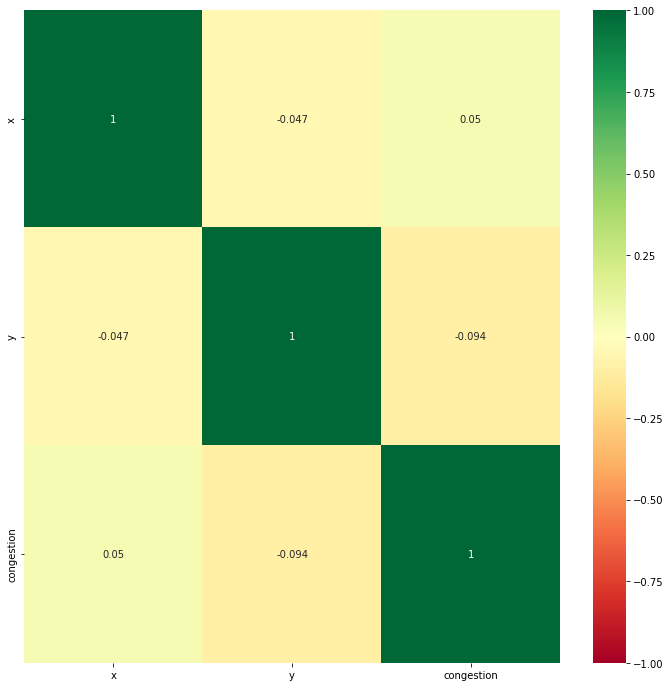

In [9]:
# Correlation matrix

sns.heatmap(train.corr(), annot=True, vmin=-1, vmax=1, cmap='RdYlGn')

In [10]:
# Load the data

test = pd.read_csv('test.csv', index_col='row_id', parse_dates=['time'])
test.head()

,time,x,y,direction
row_id,,,,
848835,1991-09-30 12:00:00,0,0,EB
848836,1991-09-30 12:00:00,0,0,NB
848837,1991-09-30 12:00:00,0,0,SB
848838,1991-09-30 12:00:00,0,1,EB
848839,1991-09-30 12:00:00,0,1,NB


There are no missing values, in the data.

In [11]:
# Missing values

if train.isna().any().any():
    print(train.isna().sum()/train.shape[0])
else:
    print("No Missing values")

No Missing values


## Preparation

In [12]:
# Add the congestion column to test data

test['congestion'] = 0.0

In [13]:
# Seperating out the data based on columns

grouped_train_data = train.groupby(['time', 'x', 'y', 'direction'])
grouped_test_data = test.groupby(['time', 'x', 'y', 'direction'])

In [14]:
# Making the train and test dicts

train_dict = dict()
test_dict = dict()

for g in grouped_train_data:
    if (g[0][1], g[0][2], g[0][3]) in train_dict.keys():
        train_dict[(g[0][1], g[0][2], g[0][3])].append((g[0][0], g[1]['congestion'].values[0]))
    else:
        train_dict[(g[0][1], g[0][2], g[0][3])] = [(g[0][0], g[1]['congestion'].values[0])]

for g in grouped_test_data:
    if (g[0][1], g[0][2], g[0][3]) in test_dict.keys():
        test_dict[(g[0][1], g[0][2], g[0][3])].append((g[0][0], g[1]['congestion'].values[0]))
    else:
        test_dict[(g[0][1], g[0][2], g[0][3])] = [(g[0][0], g[1]['congestion'].values[0])]

In [15]:
# Making the train and test dataframes

for idx, li in train_dict.items():
    train_dict[idx] = pd.DataFrame(columns=['ds', 'y'], data=li)

for idx, li in test_dict.items():
    test_dict[idx] = pd.DataFrame(columns=['ds', 'y'], data=li).drop(['y'], axis=1)

## Modelling

### Approach-1



In this method, I have grouped the data into a number of instances and made the predictions on that instances.

An instance is uniquely identifiable by its a key which is a combination of its cordinates and the direction. 

In [ ]:
# FbProphet Instantiation and Predictions

for idx, train_data in tqdm.tqdm(train_dict.items()):
    model = Prophet()
    model.fit(train_data)
    forecast = model.predict(test_dict[idx])
    test_dict[idx]['congestion'] = np.round(forecast['yhat'])
    test_dict[idx]['x'] = idx[0]
    test_dict[idx]['y'] = idx[1]
    test_dict[idx]['direction'] = idx[2]

100%|██████████| 65/65 [06:11<00:00,  5.72s/it]


### Approach-2

The approach and data grouping is same and similar to previous one, by this time we fit weekly and daily seasonality. And also logistic growth

In [21]:
# FbProphet Instantiation and Predictions

for idx, train_data in tqdm.tqdm(train_dict.items()):
    train_data['cap'] = train_data['y'].max() + train_data['y'].std() / 3
    train_data['floor'] = train_data['y'].min() - train_data['y'].std() / 3
    test_dict[idx]['cap'] = train_data['y'].max() + train_data['y'].std() / 3
    test_dict[idx]['floor'] = train_data['y'].min() - train_data['y'].std() / 3

    model = Prophet(growth='logistic', weekly_seasonality=True, daily_seasonality=True)
    model.fit(train_data)
    forecast = model.predict(test_dict[idx])

    test_dict[idx]['congestion'] = np.round(forecast['yhat'])
    test_dict[idx]['x'] = idx[0]
    test_dict[idx]['y'] = idx[1]
    test_dict[idx]['direction'] = idx[2]

100%|██████████| 65/65 [06:28<00:00,  5.98s/it]


In [22]:
# Getting the final predictions

preds_semi_final = pd.concat(test_dict.values(), ignore_index=True)
preds_final = test.reset_index().merge(preds_semi_final, left_on=['time', 'x', 'y', 'direction'], right_on=['ds', 'x', 'y', 'direction'])[['row_id', 'congestion_y']]

In [23]:
# Generating output file

submission = pd.read_csv('/content/sample_submission.csv')
submission = submission.merge(preds_final, on='row_id')[['row_id', 'congestion_y']].rename(columns={'congestion_y': 'congestion'})
submission.to_csv('output.csv', index=False)

In [24]:
# Submission

!kaggle competitions submit -c tabular-playground-series-mar-2022 -f output.csv -m "FB Prophet correct 2 with seasonality and growth"

100% 27.4k/27.4k [00:00<00:00, 67.5kB/s]
Successfully submitted to Tabular Playground Series - Mar 2022